<a href="https://colab.research.google.com/github/jrbobes/jrbobes-hitl-ml/blob/master/PAAD_XAI_Local_Global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PAAD - Random Forest - Treatment type**

author: jose.bobes at udc.es

# Importing required libraries

In [1]:
# Importing Required Libraries
import sys
print('Python: {}'.format(sys.version))

import scipy
print('scipy: {}'.format(scipy.__version__))

import numpy
print('numpy: {}'.format(numpy.__version__))

import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__))

import pandas as pd
print('pandas: {}'.format(pd.__version__))

import sklearn
print('sklearn: {}'.format(sklearn.__version__))

from sklearn import metrics

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier

Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
scipy: 1.10.1
numpy: 1.22.4
matplotlib: 3.7.1
pandas: 1.5.3
sklearn: 1.2.2


# Preparing the Pancreas data

In [2]:
# Loading Data
url = "https://raw.githubusercontent.com/jrbobes/jrbobes-hitl-ml/master/Libro1_Adapted.csv"
columns = ['ns10:file_uuid','ns2:gender', 'ns5:race', 'ns5:age_at_initial_pathologic_diagnosis', 'ns3:pathologic_T', 'ns3:pathologic_N', 'ns3:pathologic_M', 'ns3:pathologic_stage', 'ns5:vital_status', 'ns5:days_to_death', 'therapy_type']

dataset = pd.read_csv(url, sep=';', usecols=columns, encoding = "ISO-8859-1")

print(dataset.shape)
print(dataset.head())

(205, 11)
                         ns10:file_uuid ns2:gender                   ns5:race  \
0  1AF64746-0F41-408F-9CB3-D567BEBA1217     FEMALE                      WHITE   
1  0D7B23AC-0988-4E95-9AF3-82180A1DAB0A     FEMALE                      WHITE   
2  290AC731-F653-432D-8C35-8E6C178BD2C6     FEMALE                      WHITE   
3  E2FC1DD6-0B4D-409D-9D1C-0F8E0ADB6113     FEMALE  BLACK OR AFRICAN AMERICAN   
4  40A76730-988D-4FF1-A17A-91AA85DD7C76       MALE                      WHITE   

   ns5:age_at_initial_pathologic_diagnosis ns3:pathologic_stage  \
0                                       53            Stage IIB   
1                                       54            Stage IIA   
2                                       58             Stage IV   
3                                       66            Stage IIA   
4                                       64            Stage IIA   

  ns3:pathologic_T ns3:pathologic_N ns3:pathologic_M ns5:vital_status  \
0               T3         

In [3]:
# Feature Selection
# Split dataset in features and target variables (REF: https://www.datacamp.com/tutorial/decision-tree-classification-python)
feature_cols = ['ns2:gender', 'ns5:race', 'ns5:age_at_initial_pathologic_diagnosis', 'ns3:pathologic_T', 'ns3:pathologic_N', 'ns3:pathologic_M', 'ns3:pathologic_stage']

X = dataset[feature_cols] # Features
#X = dataset.drop(columns='therapy_type');
X_encoded = pd.get_dummies(X)
y = dataset.therapy_type # Target variable

In [8]:
y

0             Other
1             Other
2             Other
3      Chemotherapy
4             Other
           ...     
200    Chemotherapy
201    Chemotherapy
202           Other
203    Chemotherapy
204           Other
Name: therapy_type, Length: 205, dtype: object

In [37]:
#feature_cols = ['ns10:file_uuid', 'ns2:gender', 'ns5:race', 'ns5:age_at_initial_pathologic_diagnosis', 'ns3:pathologic_T', 'ns3:pathologic_N', 'ns3:pathologic_M', 'ns3:pathologic_stage','therapy_type']
#Z = dataset[feature_cols] # Features
#Z

In [33]:
import numpy as np
from google.colab import autoviz
df_381993596927673496 = autoviz.get_df('df_381993596927673496')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_381993596927673496, *['ns3:pathologic_T'], **{})
chart

In [34]:
from google.colab import autoviz
df_381993596927673496 = autoviz.get_df('df_381993596927673496')

def categorical_histogram(df, colname, figsize=(4, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chartStage = categorical_histogram(df_381993596927673496, *['ns3:pathologic_stage'], **{})
chartStage

In [24]:
from google.colab import autoviz
df_381993596927673496 = autoviz.get_df('df_381993596927673496')

def histogram(df, colname, num_bins=10, figsize=(4, 2)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_381993596927673496, *['ns5:age_at_initial_pathologic_diagnosis'], **{})
chart

# Creating a Random Forest model

In [55]:
# Building Random Forest Model

# Create Random Forest classifer object
rf = RandomForestClassifier(max_samples= 130, max_depth=5, bootstrap=True)

# Normalize the therapy type to only Chemotherapy or Other.
y1 = y.replace('Hormone Therapy', 'Other')
y2 = y1.replace('Vaccine', 'Other')
y = y2.replace('Ancillary', 'Other')

# Train Random Forest Classifer
rf = rf.fit(X_encoded, y)

#Predict the response for test dataset
y_pred = rf.predict(X_encoded)


In [56]:
# Evaluating Model
print("Accuracy: ", metrics.accuracy_score(y, y_pred))

Accuracy:  0.7902439024390244


In [40]:
X_encoded.columns

Index(['ns5:age_at_initial_pathologic_diagnosis', 'ns2:gender_FEMALE',
       'ns2:gender_MALE', 'ns5:race_ASIAN',
       'ns5:race_BLACK OR AFRICAN AMERICAN', 'ns5:race_WHITE',
       'ns3:pathologic_T_T1', 'ns3:pathologic_T_T2', 'ns3:pathologic_T_T3',
       'ns3:pathologic_T_T4', 'ns3:pathologic_T_TX', 'ns3:pathologic_N_N0',
       'ns3:pathologic_N_N1', 'ns3:pathologic_N_N1b', 'ns3:pathologic_N_NX',
       'ns3:pathologic_M_M0', 'ns3:pathologic_M_M1', 'ns3:pathologic_M_MX',
       'ns3:pathologic_stage_Stage I', 'ns3:pathologic_stage_Stage IA',
       'ns3:pathologic_stage_Stage IB', 'ns3:pathologic_stage_Stage IIA',
       'ns3:pathologic_stage_Stage IIB', 'ns3:pathologic_stage_Stage III',
       'ns3:pathologic_stage_Stage IV'],
      dtype='object')

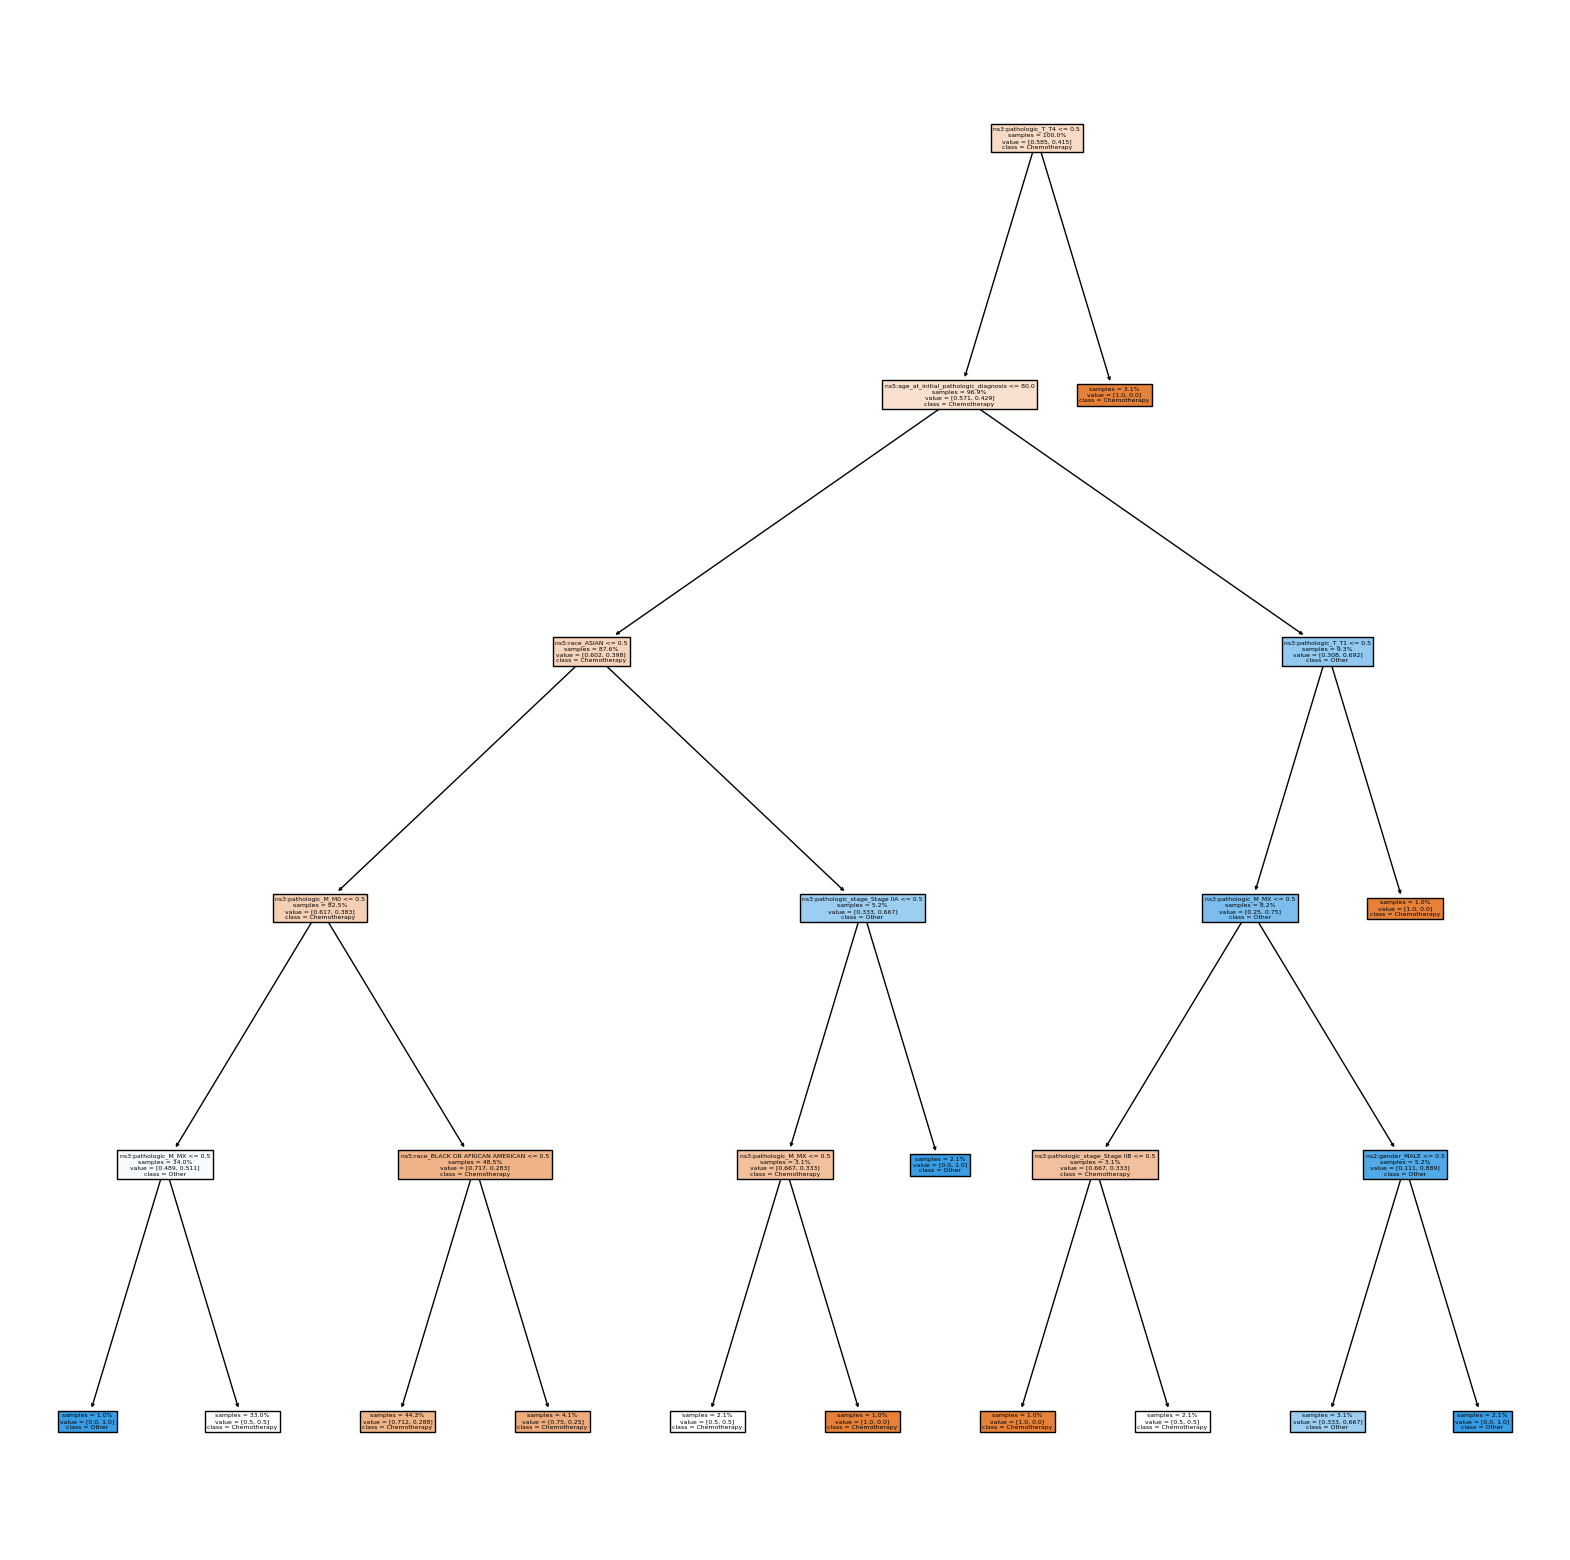

In [59]:
# Visualizing the decision tree
fig = plt.figure(figsize=((20,20)))
plot_tree(rf.estimators_[0],
            feature_names = X_encoded.columns,
            class_names=['Chemotherapy','Other'],
            impurity=False,
            proportion=True,
            filled=True)
fig.savefig('test.png')

# Exaplainability with SHAP

In [60]:
# Install SHAP (SHapley Additive exPlanations).
!pip install shap

# Import required libraries
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 18.9 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [62]:
# Explain the model's predictions using SHAP
explainerShap = shap.TreeExplainer(rf)
shap_values = explainerShap.shap_values(X_encoded)

Summary plot will give us the variable importance plot. Features with high predicting power are shown at the top and the ones with low predicting powers are shown at the bottom.

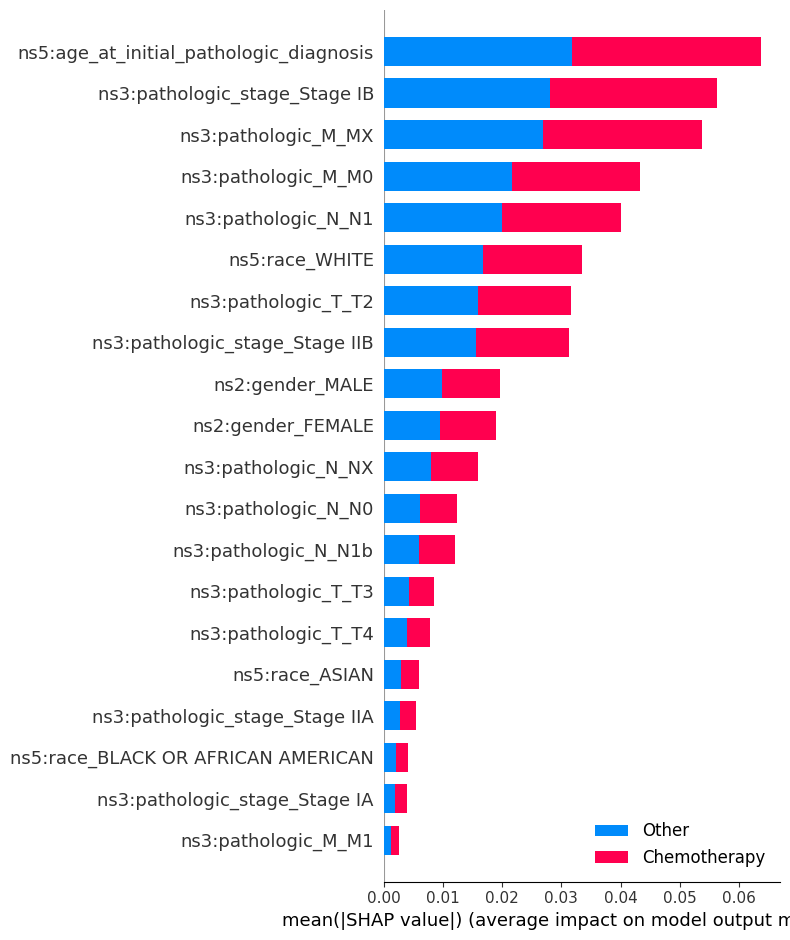

In [63]:
shap.summary_plot(shap_values, X_encoded, plot_type='bar', class_names=['Chemotherapy','Other'])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


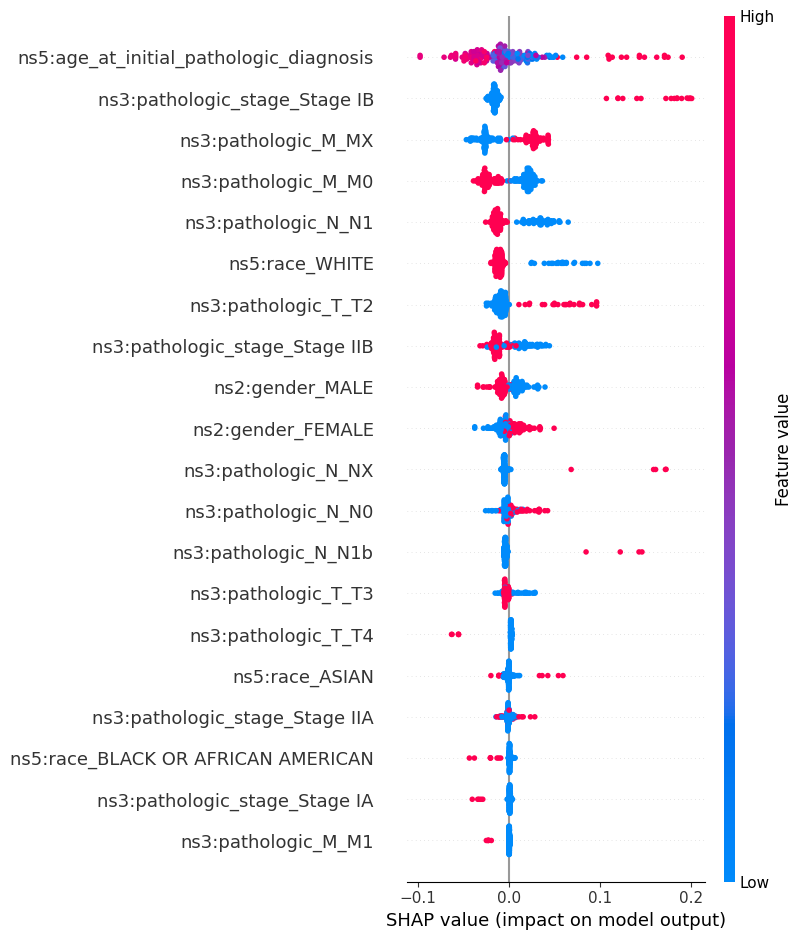

In [64]:
# Summary plot in an individual sample
shap.summary_plot(shap_values[1], X_encoded)

Ahora vamos a mostrar el **gráfico de dependencias**
The partial dependence plot is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome.

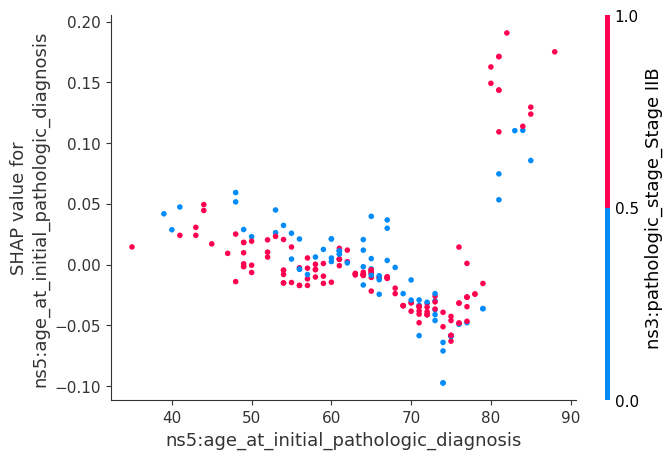

In [92]:
shap.dependence_plot(0, shap_values[1], X_encoded, feature_names = X_encoded.columns)

A continuación incluimos un gráfico de decisión:

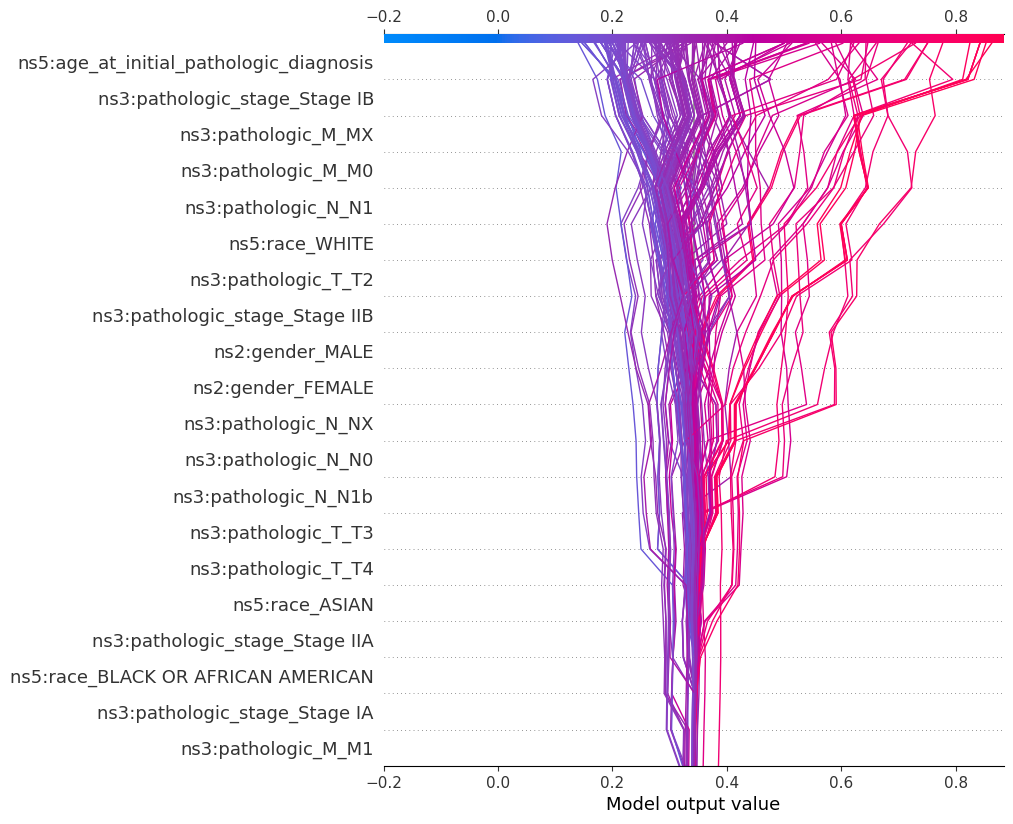

In [124]:
i=1
shap.decision_plot(explainerShap.expected_value[i], shap_values[i], feature_names = list(X_encoded.columns))

Y finalmente un gráfico de fuerzas:

In [144]:
shap.initjs()
i = 1
shap.force_plot(explainerShap.expected_value[i], shap_values[i], feature_names = list(X_encoded.columns))

# Explainability with LIME

In [65]:
# Install SHAP (SHapley Additive exPlanations).
!pip install lime

# Import required libraries
import lime
import lime.lime_tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=7b0dd9c93f76e2d0306813e176ac7510a2c0f4abd35304354885b0fa6d67e5c3
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [68]:
# XAI with LIME (Local Interpretable Model-agnostic Explanations)
explainerLime = lime.lime_tabular.LimeTabularExplainer(X_encoded.values, feature_names=X_encoded.columns, class_names = ['Chemotherapy', 'Other'], discretize_continuous=True)

exp = explainerLime.explain_instance(X_encoded.values[1], rf.predict_proba, num_features=10, top_labels=3)
exp.show_in_notebook(show_all=True)


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
